In [3]:
import pandas as pd

folder = './data/'
filename = 'heparin2_weight.csv'
df = pd.read_csv(folder+filename)
# df.columns = ['size', 'number', 'concentration', 'volume', 'area']
df.head()

,group,organ,1,2,3,4,5
0,sham+sham,spleen,50.2,57.3,62.8,50.8,103.3
1,sham+sham,thymus,39.2,41.2,56.2,36.5,35.0
2,GL261+sham,spleen,45.4,58.4,67.7,57.4,NaN
3,GL261+sham,thymus,21.0,22.0,26.8,36.7,NaN
4,GL261+hep,spleen,122.1,84.6,85.3,74.4,NaN


In [12]:
data = []

for _, row in df.iterrows():
  for i in range(5):
    data.append({
      "group": row.iloc[0],
      "organ": row.iloc[1],
      "weight": row.iloc[2+i]
    })

data

[{'group': 'sham+sham', 'organ': 'spleen', 'weight': 50.2},
 {'group': 'sham+sham', 'organ': 'spleen', 'weight': 57.3},
 {'group': 'sham+sham', 'organ': 'spleen', 'weight': 62.8},
 {'group': 'sham+sham', 'organ': 'spleen', 'weight': 50.8},
 {'group': 'sham+sham', 'organ': 'spleen', 'weight': 103.3},
 {'group': 'sham+sham', 'organ': 'thymus', 'weight': 39.2},
 {'group': 'sham+sham', 'organ': 'thymus', 'weight': 41.2},
 {'group': 'sham+sham', 'organ': 'thymus', 'weight': 56.2},
 {'group': 'sham+sham', 'organ': 'thymus', 'weight': 36.5},
 {'group': 'sham+sham', 'organ': 'thymus', 'weight': 35.0},
 {'group': 'GL261+sham', 'organ': 'spleen', 'weight': 45.4},
 {'group': 'GL261+sham', 'organ': 'spleen', 'weight': 58.4},
 {'group': 'GL261+sham', 'organ': 'spleen', 'weight': 67.7},
 {'group': 'GL261+sham', 'organ': 'spleen', 'weight': 57.4},
 {'group': 'GL261+sham', 'organ': 'spleen', 'weight': nan},
 {'group': 'GL261+sham', 'organ': 'thymus', 'weight': 21.0},
 {'group': 'GL261+sham', 'organ': 

In [17]:
df2 = pd.DataFrame.from_dict(data).dropna()

In [18]:
df2.set_index(['group', 'organ']).head()

weight
group     organ         
sham+sham spleen    50.2
          spleen    57.3
          spleen    62.8
          spleen    50.8
          spleen   103.3

In [19]:
sort_map = {
  'sham+sham': 0,
  'sham+hep': 1,
  'GL261+sham': 2,
  'GL261+hep': 3,
  'SB28+sham': 4,
  'SB28+hep': 5,
}

In [21]:
df2 = df2.sort_values('group', key=lambda x: x.map(sort_map))

In [29]:
stats = df2.groupby(['group', 'organ']).describe()
stats['weight'].head()

count     mean        std    min      25%     50%      75%  \
group      organ                                                                
GL261+hep  spleen    4.0   91.600  20.934660   74.4   82.050   84.95   94.500   
           thymus    4.0   25.800   2.721519   23.1   23.925   25.45   27.325   
GL261+sham spleen    4.0   57.225   9.146356   45.4   54.400   57.90   60.725   
           thymus    4.0   26.625   7.177918   21.0   21.750   24.40   29.275   
SB28+hep   spleen    4.0  187.750  64.213680  146.3  148.250  161.20  200.700   

                     max  
group      organ          
GL261+hep  spleen  122.1  
           thymus   29.2  
GL261+sham spleen   67.7  
           thymus   36.7  
SB28+hep   spleen  282.3

In [31]:
mean_stats = stats['weight'].loc[:, ['mean']]
mean_stats.head()

mean
group      organ          
GL261+hep  spleen   91.600
           thymus   25.800
GL261+sham spleen   57.225
           thymus   26.625
SB28+hep   spleen  187.750

In [34]:
out = mean_stats.sort_index(level='group', key=lambda x: x.map(sort_map))
out.head()

mean
group      organ            
sham+sham  spleen  64.880000
           thymus  41.620000
sham+hep   spleen  71.933333
           thymus  26.800000
GL261+sham spleen  57.225000

In [35]:
from scipy.stats import ttest_ind

out['p-value'] = ''
out['95% CI'] = ''

comparison_groups = (
  ('sham+sham', 'GL261+sham'),
  ('sham+sham', 'SB28+sham'),
  ('sham+hep', 'GL261+hep'),
  ('sham+hep', 'SB28+hep'),
)

organs = (
  'spleen',
  'thymus',
)

for subgroup in comparison_groups:
  for organ in organs:
    vector_filter = (df2['organ'] == organ)
    res = ttest_ind(
      df2.loc[vector_filter & (df2['group'] == subgroup[0]), 'weight'],
      df2.loc[vector_filter & (df2['group'] == subgroup[1]), 'weight'],
    )
    ci = res.confidence_interval()
    out.at[(subgroup[1], organ), 'p-value'] = f"{res.pvalue:.2f}{'**' if res.pvalue < 0.05 else ''}"
    out.at[(subgroup[1], organ), '95% CI'] = f"[{ci.low:.2f}, {ci.high:.2f}]"

out

mean p-value             95% CI
group      organ                                        
sham+sham  spleen   64.880000                           
           thymus   41.620000                           
sham+hep   spleen   71.933333                           
           thymus   26.800000                           
GL261+sham spleen   57.225000    0.54    [-20.48, 35.79]
           thymus   26.625000  0.03**      [2.37, 27.62]
GL261+hep  spleen   91.600000    0.20    [-53.49, 14.16]
           thymus   25.800000    0.77      [-7.20, 9.20]
SB28+sham  spleen   44.760000    0.08     [-2.97, 43.21]
           thymus   22.240000  0.00**      [8.98, 29.78]
SB28+hep   spleen  187.750000  0.03**  [-214.14, -17.49]
           thymus   18.575000    0.10     [-2.46, 18.91]

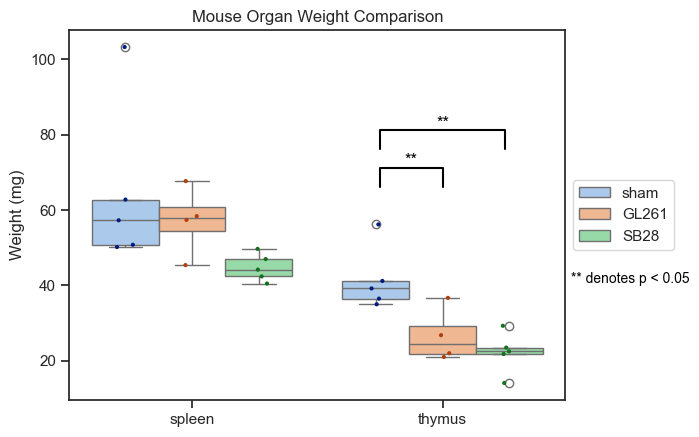

In [81]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="ticks", palette="pastel")

data = df2.loc[(df2['group'] == 'sham+sham') | (df2['group'] == 'GL261+sham') | (df2['group'] == 'SB28+sham')]
data.loc[:, 'group'] = data.loc[:, 'group'].replace({
  'sham+sham': 'sham',
  'GL261+sham': 'GL261',
  'SB28+sham': 'SB28'
})

# Create the boxplot
g = sns.boxplot(
  data=data,
  x="organ", y="weight",
  hue="group"
)
sns.stripplot(
  data=data,
  x="organ", y="weight",
  hue="group", palette='dark',
  size=3, dodge=True,
  legend=False
)

# Set the title and labels
g.set_title('Mouse Organ Weight Comparison')
g.set_ylabel('Weight (mg)')
g.set_xlabel('')

# Adjust the legend
handles, labels = g.get_legend_handles_labels()
g.legend(handles[:3], labels[:3], loc='center left', bbox_to_anchor=(1, 0.5), title=None)

# Add significance lines and asterisks
def add_significance_line(ax, x1, x2, y, h, text):
    """
    Draw a line with text indicating significance between two points.
    
    ax : matplotlib axis object
        The axis to draw the line on.
    x1, x2 : float
        The x coordinates of the start and end points of the line.
    y : float
        The y coordinate of the line.
    h : float
        The height of the line above the boxplot.
    text : str
        The text to display above the line.
    """
    ax.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1.5, color='black')
    ax.text((x1 + x2) * 0.5, y + h, text, ha='center', va='bottom', color='black')

# y is the baseline height, h is the height of the line
y = data.loc[data['organ'] == 'thymus']['weight'].max() + 10
h = 5

# Add significance lines (example, adjust positions as necessary)
add_significance_line(g, 0.75, 1, y, h, '**')  # Between 'sham' and 'GL261' for 'Liver'
add_significance_line(g, 0.75, 1.25, y+10, h, '**')  # Between 'sham' and 'SB28' for 'Heart'
g.text(1.75, 40, '** denotes p < 0.05', ha='center', va='bottom', color='black', fontsize=10)

plt.show()
